In [1]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

## Hamiltonian path example

<img src="Hamiltonian path example.png" alt="drawing" width="500"/>

1. Define the graph as NxN matrix

In [2]:
# Graph
g = np.array([[0,1,1,0,1,1],
              [1,0,1,0,0,0],
              [1,1,0,1,0,1],
              [0,0,1,0,1,1],
              [1,0,0,1,0,1],
              [1,0,1,1,1,0]])
# g = np.array([[0, 1, 1, 1, 1],
#              [1, 0, 1, 1, 1],
#              [1, 1, 0, 1, 1],
#              [1, 1, 1, 0, 1],
#              [1, 1, 1, 1, 0]])


In [3]:
n_vertices = g.shape[0]
n_edges = 0
for i in range(n_vertices):
    n_edges += sum(g[i, i:])
print('number of vertices:', n_vertices)
print('number of edges:', n_edges)
print('required qubit number:', n_vertices + n_edges + 1)
iter = int(np.pi/(4*np.arcsin(1/np.sqrt(2**n_edges))) - 1/2)
# iter = np.pi/4 * np.sqrt(2**n_edges)
print('Grover iteration:', iter)

number of vertices: 6
number of edges: 10
required qubit number: 17
Grover iteration: 24


2. Convert matrix to dictionary type.

In [4]:
g_dict = {} # {edge: [vertex1, vertex2]}

edge_idx = 0
for i in range(n_vertices):
    for j in range(i, n_vertices):
        if g[i,j] == 1:
            g_dict[edge_idx] = [i, j]
            edge_idx += 1
g_dict

{0: [0, 1],
 1: [0, 2],
 2: [0, 4],
 3: [0, 5],
 4: [1, 2],
 5: [2, 3],
 6: [2, 5],
 7: [3, 4],
 8: [3, 5],
 9: [4, 5]}

3. Design the oracle and the diffuser

In [5]:
def oracle(qc, qr_v, qr_e, qr_f, n_vertices):
    # encode
    for i in g_dict:
        qc.cry(np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()

    # set flag
    qc.mcx(v, flag)
    qc.barrier()

    # inverse
    for i in g_dict:
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()
    
def diffuser(qc, qr_e, ancilla):
    qc.h(qr_e)
    qc.x(qr_e)
    qc.h(qr_e[-1])
    qc.mct(qr_e[:-1], qr_e[-1])#, ancilla_qubits=ancilla)
    qc.h(qr_e[-1])
    qc.x(qr_e)
    qc.h(qr_e)

4. Design the quantum circuit with Grover iteration

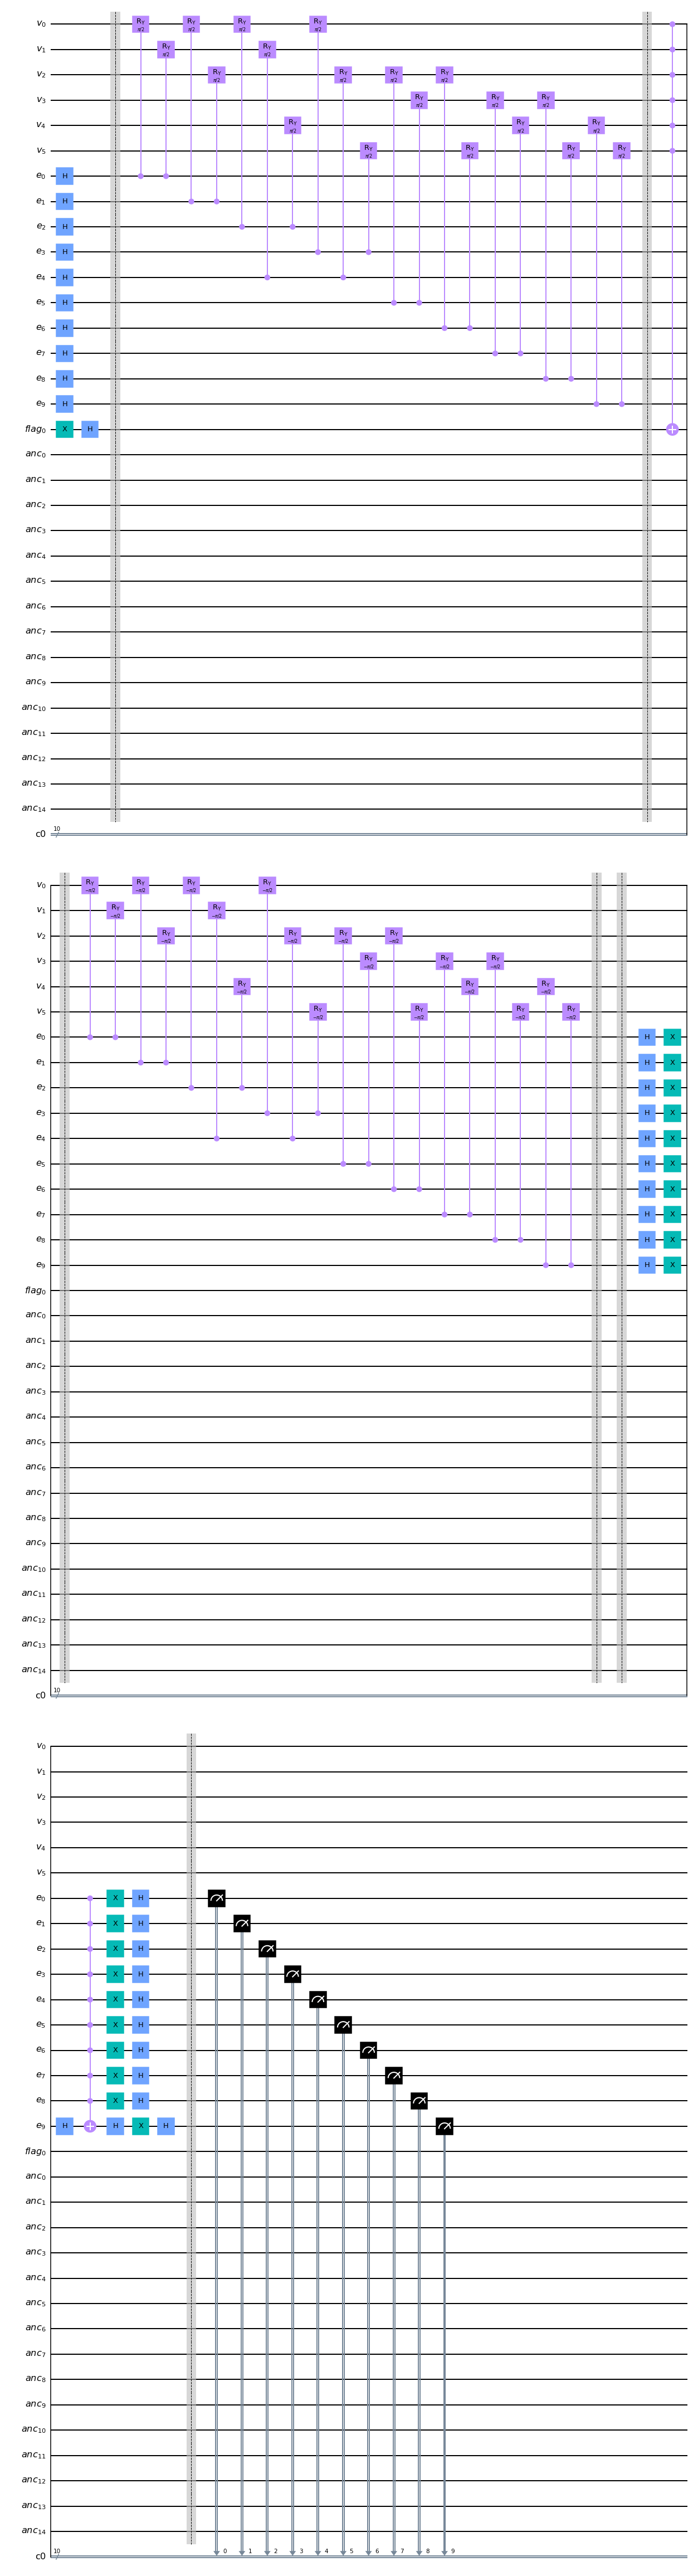

In [6]:
v = QuantumRegister(n_vertices, name='v')
e = QuantumRegister(n_edges, name='e')
flag = QuantumRegister(1, name='flag')
n_anc = 32-n_vertices-n_edges-1
anc = QuantumRegister(n_anc, name='anc')

c = ClassicalRegister(n_edges)

qc = QuantumCircuit(v, e, flag, anc, c)

qc.h(e)

qc.x(flag)
qc.h(flag)

qc.barrier()
iter = 1
for _ in range(iter):
    oracle(qc, v, e, flag, n_vertices)
    qc.barrier()
    diffuser(qc, e, anc)
    qc.barrier()


qc.measure(e, c)
qc.draw('mpl')

5. Run the simulator

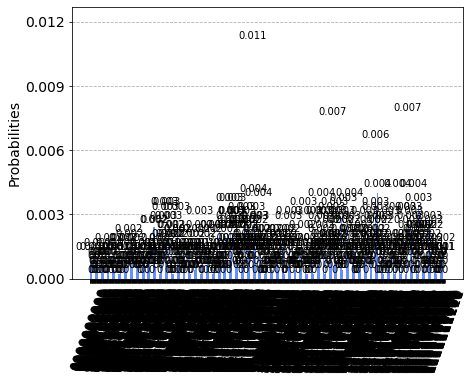

In [7]:
shots = 5012
backend = Aer.get_backend('qasm_simulator')
count = execute(qc, backend=backend, shots=shots).result().get_counts()
plot_histogram(count)

6. Define postprocess function.

The function filters out non-Hamiltonian cycle (sub Hamiltonian cycle)

<img src="Hamiltonian sub cycle.png" alt="drawing" width="500"/>
<center>[Hamiltonian sub-cycle]</center>

In [8]:
from collections import defaultdict

class Graph:    

    # Constructor
    def __init__(self):

        # default dictionary to store graph
        self.graph = defaultdict(list)

    # function to add an edge to graph
    def addEdge(self,u,v):
        self.graph[u].append(v)
        self.graph[v].append(u)

    # Function to print a BFS of graph
    def BFS(self, s):

        # Mark all the vertices as not visited
        visited = [False] * (max(self.graph) + 1)

        # Create a queue for BFS
        queue = []
        count = 0

        # Mark the source node as
        # visited and enqueue it
        queue.append(s)
        visited[s] = True
        count += 1

        while queue:

            # Dequeue a vertex from
            # queue and print it
            s = queue.pop(0)

            # Get all adjacent vertices of the
            # dequeued vertex s. If a adjacent
            # has not been visited, then mark it
            # visited and enqueue it
            for i in self.graph[s]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
                    count += 1
        return count

def postprocess(count, g_dict, n_vertices):
    sorted_count = {k: t for k, t in sorted(count.items(), key=lambda item: item[1], reverse=True)}
    m = max(sorted_count.values())
    filtered_count = {}
    for k in sorted_count:
        if sorted_count[k] > m/2+1:
            filtered_count[k] = sorted_count[k]
        else:
            break
    answer = []
    for k in filtered_count.keys():
        g = Graph()
        for i, v in enumerate(k[::-1]):
            if v == '1':
                g.addEdge(g_dict[i][0], g_dict[i][1])
        if g.BFS(0) == n_vertices:
            answer.append(k)
    return answer

7. Apply postprocess.

We successfully found correct cycles.

In [9]:
postprocess(count, g_dict, n_vertices)

['0111010101', '1010111001', '1100110101']